<a href="https://colab.research.google.com/github/hadi-ansari/TFX/blob/main/Cat_%26_Dog_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple TFX Pipeline Tutorial using cats & dogs dataset

***A pipeline to train a model for recognizing cats and dogs.***

In this notebook-based tutorial, we will create and run a TFX pipeline
for a simple classification model.
The pipeline will consist of three essential TFX components: ExampleGen,
Trainer and Pusher. The pipeline includes the most minimal ML workflow like
importing data, training a model and exporting the trained model.

Please see
[Understanding TFX Pipelines](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines)
to learn more about various concepts in TFX.

## Set Up
We first need to install the TFX Python package and download
the dataset which we will use for our model.

### Upgrade Pip

In [ ]:
!pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U tfx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

### Uninstall shapely

TODO(b/263441833) This is a temporal solution to avoid an
ImportError. Ultimately, it should be handled by supporting a
recent version of Bigquery, instead of uninstalling other extra
dependencies.

In [ ]:
!pip uninstall shapely -y

Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1


### Did you restart the runtime?

If you are using Google Colab, the first time that you run
the cell above, you must restart the runtime by clicking
above "RESTART RUNTIME" button or using "Runtime > Restart
runtime ..." menu. This is because of the way that Colab
loads packages.

# Necessary imports

We also check the TensorFlow and TFX versions.

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import tensorflow as tf

print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.11.1
TFX version: 1.12.0


In [36]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ismailsafwat1","key":"7b0531deedec78ff800fd18b88fd120b"}'}

Because TFX ExampleGen reads inputs from a directory, we need to create a
directory and copy dataset to it.

In [37]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
'chmod 600 /root/.kaggle/kaggle.json'
!kaggle datasets download -d salader/dogs-vs-cats
!unzip dogs-vs-cats.zip
!rm -rf test train dogs-vs-cats.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/dogs/dog.4419.jpg  
  inflating: train/dogs/dog.442.jpg  
  inflating: train/dogs/dog.4420.jpg  
  inflating: train/dogs/dog.4421.jpg  
  inflating: train/dogs/dog.4422.jpg  
  inflating: train/dogs/dog.4424.jpg  
  inflating: train/dogs/dog.4425.jpg  
  inflating: train/dogs/dog.4426.jpg  
  inflating: train/dogs/dog.4427.jpg  
  inflating: train/dogs/dog.4431.jpg  
  inflating: train/dogs/dog.4433.jpg  
  inflating: train/dogs/dog.4436.jpg  
  inflating: train/dogs/dog.4438.jpg  
  inflating: train/dogs/dog.4439.jpg  
  inflating: train/dogs/dog.444.jpg  
  inflating: train/dogs/dog.4440.jpg  
  inflating: train/dogs/dog.4441.jpg  
  inflating: train/dogs/dog.4442.jpg  
  inflating: train/dogs/dog.4443.jpg  
  inflating: train/dogs/dog.4444.jpg  
  inflating: train/dogs/dog.4445.jpg  
  inflating: train/dogs/dog.4446.jpg  
  inflating: train/dogs/dog.445.jpg  
  inflating: train/dogs/dog.4450.jpg  
  inflating: tra

# Reduce size of the dataset (optional)
We reduce size of the dataset by removing the images from both train and test folders. Train images decreas from 10000 images to 50 and test images decreas from 2500 to 10 images to make the process faster (OBS: just for testing).

In [38]:
!ls -1 dogs_vs_cats/train/dogs/* | tail -n +501 | xargs rm 
!ls -1 dogs_vs_cats/train/cats/* | tail -n +501 | xargs rm

!ls -1 dogs_vs_cats/test/dogs/* | tail -n +101 | xargs rm 
!ls -1 dogs_vs_cats/test/cats/* | tail -n +101 | xargs rm 

### Set up variables

There are some variables used to define a pipeline. You can customize these
variables as you want. By default all output from the pipeline will be
generated under the current directory.

In [39]:
_trainer_module_file = 'dogs_vs_cats_trainer.py'

data_root ='dogs_vs_cats'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 128
PIPELINE_NAME = 'dogs_vs_cats_pipeline'
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'cat&dog_md.db')


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 500
total training dog images: 500
total validation cat images: 100
total validation dog images: 100
--
Total training images: 1000
Total validation images: 200


# Conversion of image dataset to TFRecords

We followed the instructions according [this](https://ai.plainenglish.io/a-quick-and-simple-guide-to-tfrecord-c421337a6562).


In [40]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import random
import cv2
import matplotlib.pyplot as plt

# Setup the train and test imgage directories
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")

# setup train and test TFRecord file
train_tfrecord='train_data.tfrecords'
test_tfrecord = 'test_data.tfrecords'

# Define the name of folders of each class
# We only have two classes in this case.
folders=['dogs', 'cats']

# List all train and test image path
train_image_path=[]
test_image_path=[]

for i in range(len(folders)):
    for file in os.listdir(os.path.join(train_dir, folders[i])):
        train_image_path.append(os.path.join(train_dir, folders[i], file))
    for file in os.listdir(os.path.join(test_dir, folders[i])):
        test_image_path.append( os.path.join(test_dir, folders[i], file))


print("Number of train images found: ", len(train_image_path))
print("Number of test images found: ", len(test_image_path))

# Shuffle the image paths for better accuracy and precision
random.seed(0)
random.shuffle(train_image_path)
random.shuffle(test_image_path)

# create train and test lables for shuffled image paths
# 0 for cat and 1 for dog
train_labels=[]
test_labels=[]
for i in range(len(train_image_path)):
    if os.path.basename(train_image_path[i])[:3]=='cat':
        train_labels.append(0)
    else:
        train_labels.append(1)

for i in range(len(test_image_path)):
    if os.path.basename(test_image_path[i])[:3]=='cat':
        test_labels.append(0)
    else:
        test_labels.append(1)

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""    
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def serialize_example(image_string, label):
    ## Create a dictionary with features for images and their target labels
    image_shape = tf.io.decode_jpeg(image_string).shape

    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
    }
    #  Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    #serializes the message and returns it as a string. Note that the bytes are binary
    return example_proto.SerializeToString()

def write_TFRecord(image_path, label):
    image_string = open(image_path, 'rb').read()
    example = serialize_example(image_string, label)
    return example

#Write Train TFRecord file
with tf.io.TFRecordWriter(train_tfrecord) as writer:
    for image_path, label in zip(train_image_path, train_labels):
        writer.write(write_TFRecord(image_path, int(label)))
#Write Test TFRecord file
with tf.io.TFRecordWriter(test_tfrecord) as writer:
    for image_path, label in zip(test_image_path, test_labels):
         writer.write(write_TFRecord(image_path, int(label)))

Number of train images found:  1000
Number of test images found:  200


In [41]:
!rm -rf dataset
!mkdir dataset
!mkdir dataset/train
!mkdir dataset/test
!mv train_data.tfrecords dataset/train
!mv test_data.tfrecords dataset/test

### Write model training code

We will create a simple DNN model for cats vs dogs classification using TensorFlow Keras
API. This model training code will be saved to a separate file.

For model training code we found this tutorial on Kaggle
[here](https://www.kaggle.com/code/alpaca0984/dogs-vs-cats-tensorflow-2-0-on-google-colab). You need to write a Python file
containing `run_fn` function, which is the entrypoint for the `Trainer`
component.

#Pipeline Definition
We define the ML pipeline here. The components of the pipeline are: ImportExampleGen for ingesting the images into the pipeline, Trainer for training the model and Pusher component for serving the model into production environment.

For ingesting the image dataset into the pipeline, we got help from this github repository [github](https://github.com/tensorflow/tfx/blob/master/tfx/examples/cifar10/cifar10_pipeline_native_keras.py)

In [42]:
from tfx.components.example_gen.component import FileBasedExampleGen
from tfx.dsl.components.base import executor_spec
from tfx.components.example_gen.csv_example_gen import executor
from tfx.dsl.components.base.base_executor import BaseExecutor
from tfx.proto import example_gen_pb2
from tfx.components import ImportExampleGen
from tfx.proto import trainer_pb2


def _create_pipeline(pipeline_name: str, pipeline_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  print("Pipeline creation is running...\n\n\n")

  """Creates a three component penguin pipeline with TFX."""
 
  input_config = example_gen_pb2.Input(splits=[
      example_gen_pb2.Input.Split(name='train', pattern='train/*'),
      example_gen_pb2.Input.Split(name='eval', pattern='test/*')
  ])

  # Brings data into the pipeline.
  example_gen = ImportExampleGen(
      input_base='/content/dataset', input_config=input_config)
  

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=100),
      eval_args=tfx.proto.EvalArgs(num_steps=5))

  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      trainer,
      #pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [63]:
%%writefile {_trainer_module_file}

import tensorflow as tf
from tfx import v1 as tfx
import matplotlib.pyplot as plt
import tensorflow_transform as tft
from tfx_bsl.tfxio import dataset_options
import os
import gzip
from typing import List
from tensorflow_metadata.proto.v0 import schema_pb2
from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_transform.tf_metadata import schema_utils


_LABEL_KEY = 'label'
IMG_HEIGHT = 150
IMG_WIDTH = 150
batch_size = 128

_TRAIN_DATA_SIZE = 1000
_TEST_DATA_SIZE = 200

_FEATURE_SPEC = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}


# Define a function to parse the tfrecord dataset
def _parse_function(features, label):
  image = tf.io.decode_jpeg(features['image_raw'], channels=3)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    
  return image, label

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int = 128) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema)


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  
    epochs = 10
    #Create the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
 
    # Print a summary of the model
    model.summary()

    schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

    # Load the training dataset
    train_ds = _input_fn(
        fn_args.train_files,
        fn_args.data_accessor,
        schema,
        batch_size=batch_size)

    train_ds = train_ds.unbatch()
    train_ds = train_ds.map(_parse_function)
    train_ds = train_ds.batch(batch_size)


    # Load the test dataset
    eval_ds = _input_fn(
        fn_args.eval_files,
        fn_args.data_accessor,
        schema,
        batch_size=batch_size)
    
    eval_ds = eval_ds.unbatch()
    eval_ds = eval_ds.map(_parse_function)
    eval_ds = eval_ds.batch(batch_size)


    steps_per_epoch = int(_TRAIN_DATA_SIZE / batch_size)
    validation_steps = int(_TEST_DATA_SIZE / batch_size)


    # Train our model
    history = model.fit(train_ds, epochs=epochs, validation_data=eval_ds,steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)


    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # The result of the training should be saved in `fn_args.serving_model_dir`
    # directory.
    model.save(fn_args.serving_model_dir, save_format='tf')


Overwriting dogs_vs_cats_trainer.py


## Run the pipeline

TFX supports multiple orchestrators to run pipelines.
In this tutorial we will use `LocalDagRunner` which is included in the TFX
Python package and runs pipelines on local environment.
We often call TFX pipelines "DAGs" which stands for directed acyclic graph.

`LocalDagRunner` provides fast iterations for development and debugging.
TFX also supports other orchestrators including Kubeflow Pipelines and Apache
Airflow which are suitable for production use cases.

See
[TFX on Cloud AI Platform Pipelines](https://www.tensorflow.org/tfx/tutorials/tfx/cloud-ai-platform-pipelines)
or
[TFX Airflow Tutorial](https://www.tensorflow.org/tfx/tutorials/tfx/airflow_workshop)
to learn more about other orchestration systems.

Now we create a `LocalDagRunner` and pass a `Pipeline` object created from the
function we already defined.

The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

Pipeline creation is running...





Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 conv2d_121 (Conv2D)         (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 conv2d_123 (Conv2D)         (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                

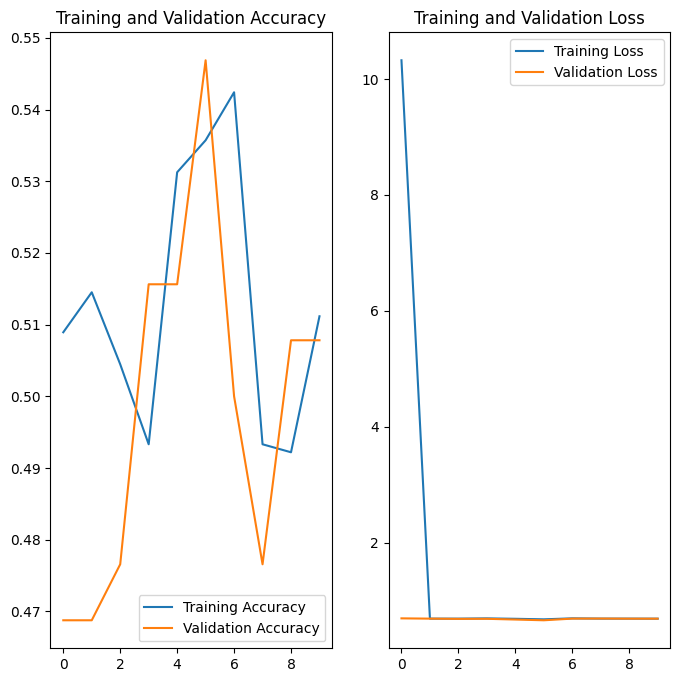

In [64]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

You should see "INFO:absl:Component Pusher is finished." at the end of the
logs if the pipeline finished successfully. Because `Pusher` component is the
last component of the pipeline.

The pusher component pushes the trained model to the `SERVING_MODEL_DIR` which
is the `serving_model/penguin-simple` directory if you did not change the
variables in the previous steps. You can see the result from the file browser
in the left-side panel in Colab, or using the following command:

In [ ]:
# List files in created model directory.
!find {SERVING_MODEL_DIR}

## Next steps

You can find more resources on https://www.tensorflow.org/tfx/tutorials.

Please see
[Understanding TFX Pipelines](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines)
to learn more about various concepts in TFX.
